<a href="https://colab.research.google.com/github/ASWANTH-J/walmart-sales-predcition/blob/main/walmart_sales_prediction_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('walmart-sales-prediction')
jovian.set_colab_id('1J5Z7YTCoGH0bdhXVMaOcpFoQ1zMZr_mW')

# walmart-sales-prediction

This project is based on the kaggle competition Walmart Recruiting - Store Sales Forecasting

Competition link : https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

Aim : To predict the weekly sales of the different walmart stores

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="walmart-sales-prediction")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/aswanthjeje28/walmart-sales-prediction


'https://jovian.ai/aswanthjeje28/walmart-sales-prediction'

# Importing Libraries,Classes,Methods

In [ ]:
!pip install opendatasets

In [ ]:
!pip install xgboost

In [ ]:
#importing all libarires,function,classes to the notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import opendatasets as od
import warnings
warnings.filterwarnings('ignore')
import os
from os import walk
from zipfile import ZipFile

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
#downloading the dataset from kaggle
od.download("https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data")

Skipping, found downloaded files in "./walmart-recruiting-store-sales-forecasting" (use force=True to force download)


#Loading datasets

There are 4 csv files available as the dataset

stores.csv - This file contains anonymized information about the 45 stores, indicating the type and size of store.

train.csv - This is the historical training data, which covers to 2010-02-05 to 2012-11-01.

test.csv - This file is identical to train.csv, except we have withheld the weekly sales.

features.csv - This file contains additional data related to the store, department, and regional activity for the given dates

In [ ]:
dir='./walmart-recruiting-store-sales-forecasting'
os.chdir(dir)

In [ ]:
#extracting zip files into csv file
for (root,dirs,files) in walk('.'):
    for file in files :
        if file.endswith('.zip'):
            with ZipFile(file) as f:
                f.extractall()

In [ ]:
#loading data into the notebook
train_df = pd.read_csv('train.csv',parse_dates=True)
test_df = pd.read_csv('test.csv',parse_dates=True)
features_df = pd.read_csv('features.csv',parse_dates=True)
stores_df = pd.read_csv('stores.csv',parse_dates=True)
ss = pd.read_csv('sampleSubmission.csv')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [ ]:
# Execute this to save new versions of the notebook
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/aswanthjeje28/walmart-sales-prediction


'https://jovian.ai/aswanthjeje28/walmart-sales-prediction'


# Data Preparation before analysis

Before doing any further analysis we will join all the datasets into one single dataframe called full_df.

So that we can analyse complete data in one dataframe

In [ ]:
merge_train_df = pd.merge(train_df,features_df,how="inner",on=["Store","Date"])
merge_train_df = pd.merge(merge_train_df,stores_df,how="inner",on=["Store"])

In [ ]:
merge_test_df = pd.merge(test_df,features_df,how="inner",on=["Store","Date"])
merge_test_df = pd.merge(merge_test_df,stores_df,how="inner",on=["Store"])

In [ ]:
full_df = pd.concat([merge_train_df,merge_test_df],axis=0).reset_index(drop=True)

## spliting date into day,month,year

In [ ]:
#spliting date column into seperate day,month,year columns
full_df['Date'] = pd.to_datetime(full_df['Date'])
full_df['Day'] = full_df.Date.dt.day
full_df['Month'] = full_df.Date.dt.month
full_df['Year'] = full_df.Date.dt.year

In [ ]:


#after basic preparation spliting back to train and test sets
merge_train_df = full_df[:train_df.shape[0]]
merge_test_df =  full_df[train_df.shape[0]:]

#Exploratory Data Analysis

Now we analyse the data set using various graphs and charts

##Brief overview of the datasets

In [ ]:
print(f"\nTrain set has {train_df.shape[0]} rows and {train_df.shape[1]} columns")
print(f"\nTest set has {test_df.shape[0]} rows and {test_df.shape[1]} columns")


Train set has 421570 rows and 5 columns

Test set has 115064 rows and 4 columns


In [ ]:
full_df.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size,Day,Month,Year
536629,45,93,2013-07-26,NaN,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,B,118221,26,7,2013
536630,45,94,2013-07-26,NaN,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,B,118221,26,7,2013
536631,45,95,2013-07-26,NaN,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,B,118221,26,7,2013
536632,45,97,2013-07-26,NaN,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,B,118221,26,7,2013
536633,45,98,2013-07-26,NaN,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False,B,118221,26,7,2013


In [ ]:
#target column
target = 'Weekly_Sales'

#primary features
p_features = [col for col in merge_train_df.columns if col not in[target]]

### Missing values

Analysis on missing values in the dataset

In [ ]:
merge_train_df[p_features].isnull().sum()/merge_train_df.shape[0]*100

Store            0.000000
Dept             0.000000
Date             0.000000
IsHoliday_x      0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       64.257181
MarkDown2       73.611025
MarkDown3       67.480845
MarkDown4       67.984676
MarkDown5       64.079038
CPI              0.000000
Unemployment     0.000000
IsHoliday_y      0.000000
Type             0.000000
Size             0.000000
Day              0.000000
Month            0.000000
Year             0.000000
dtype: float64

In [ ]:
merge_test_df[p_features].isnull().sum()/merge_test_df.shape[0]*100

Store            0.000000
Dept             0.000000
Date             0.000000
IsHoliday_x      0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1        0.129493
MarkDown2       24.879198
MarkDown3        8.542203
MarkDown4       11.200723
MarkDown5        0.000000
CPI             33.165890
Unemployment    33.165890
IsHoliday_y      0.000000
Type             0.000000
Size             0.000000
Day              0.000000
Month            0.000000
Year             0.000000
dtype: float64

In [ ]:
full_df[p_features].isnull().sum()/full_df.shape[0]*100

Store            0.000000
Dept             0.000000
Date             0.000000
IsHoliday_x      0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       50.507049
MarkDown2       63.162043
MarkDown3       54.843338
MarkDown4       55.809173
MarkDown5       50.339337
CPI              7.111365
Unemployment     7.111365
IsHoliday_y      0.000000
Type             0.000000
Size             0.000000
Day              0.000000
Month            0.000000
Year             0.000000
dtype: float64

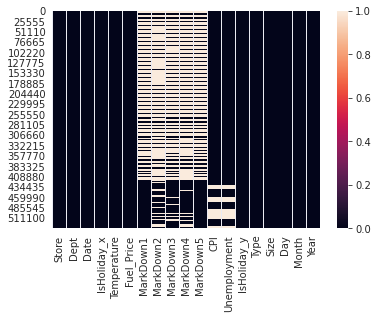

In [ ]:

sns.heatmap(full_df[p_features].isnull())

## Analysing each features

Now we are going to analyse features using univariate and multivariate graphs

In [ ]:
markdown_cols = ['MarkDown{0}'.format(i) for i in range(1,6)]
p_features = list(set(p_features)-set(markdown_cols))

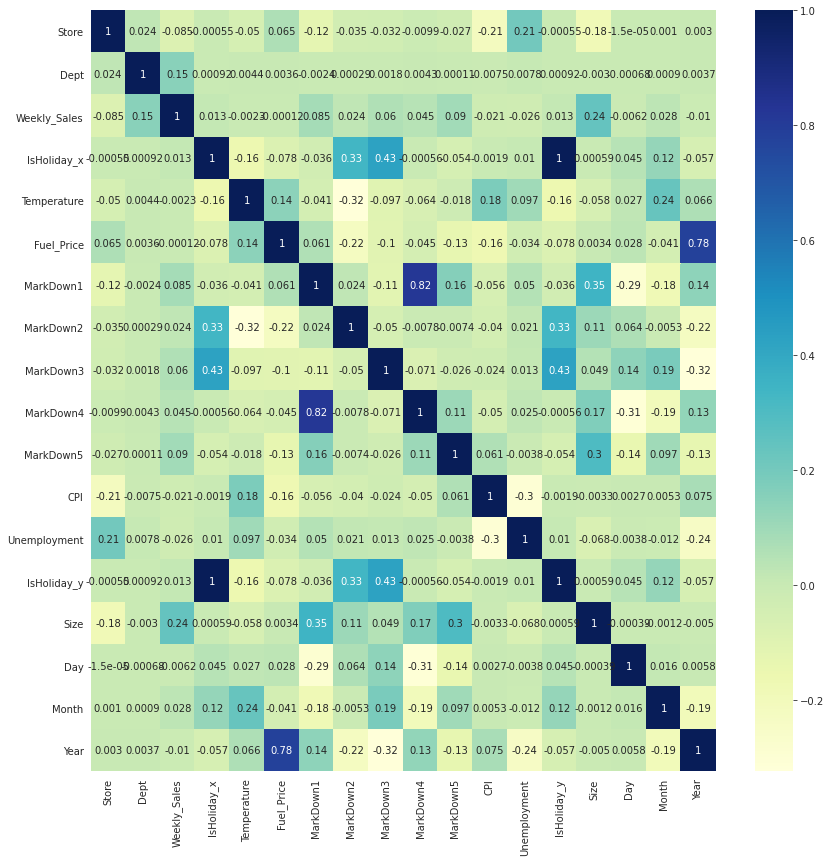

In [ ]:
plt.figure(figsize=(14,14))
sns.heatmap(merge_train_df.corr(),annot=True,cmap='YlGnBu')

Average sales on holiday week and normal week


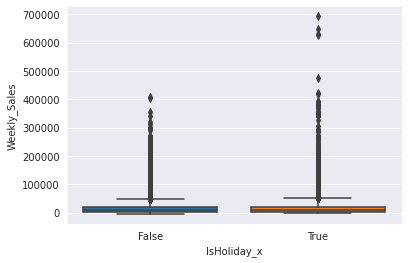

In [ ]:
sns.boxplot(x='IsHoliday_x',y=target,data=merge_train_df)

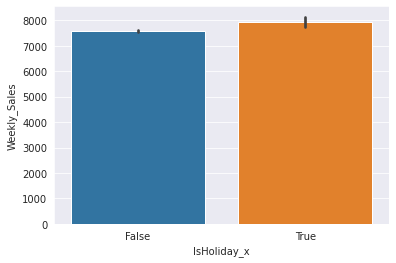

In [ ]:
sns.barplot(x='IsHoliday_x',y=target,data=merge_train_df,estimator=np.median)

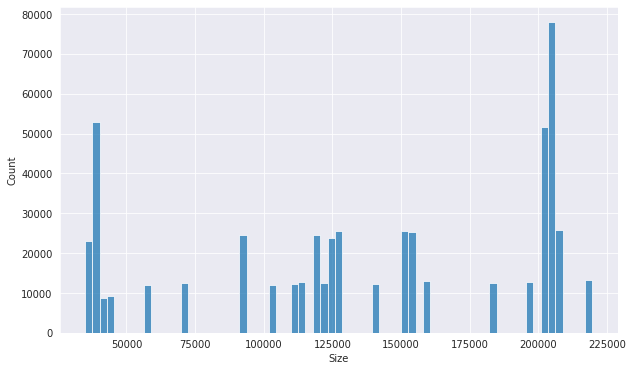

In [ ]:
ax=plt.figure(figsize=(10,6))
sns.histplot(full_df.Size)

# Data Preparation

## Missing value imputation

Half of the Values in markdown columns are not available so it's better to remove the markdown columns from the training data 

In [ ]:
full_df = pd.concat([merge_train_df,merge_test_df],axis=0)

In [ ]:
#removing markdown columns
full_df.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],axis=1,inplace=True)

In [ ]:
#IsHoliday column repeats twice in the dataset
#so removing one and renaming the remaining one

full_df.drop(['IsHoliday_y'],axis=1,inplace=True)
full_df.rename({'IsHoliday_x':'IsHoliday'},axis=1,inplace=True)

There some missing values in the features CPI,Unemployment. And those missing values are on the test set. Using simple linear regression model to predict those missing values

### CPI

In [ ]:
def rmse(y_true,y_pred):
  return mean_squared_error(y_true,y_pred,squared=False)

In [ ]:
features= ['Store','Fuel_Price','Day','Month','Year','Temperature']

In [ ]:
X = full_df[~full_df.CPI.isnull()][features]
y = full_df[~full_df.CPI.isnull()].CPI
X_test = full_df[full_df.CPI.isnull()][features]
y_test = full_df[full_df.CPI.isnull()].CPI
model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X_test)
full_df.loc[full_df.CPI.isnull(),'CPI'] = y_pred

### Unemployment

In [ ]:
X = full_df[~full_df.Unemployment.isnull()][features]
y = full_df[~full_df.Unemployment.isnull()].Unemployment
X_test = full_df[full_df.Unemployment.isnull()][features]
y_test = full_df[full_df.Unemployment.isnull()].Unemployment
model = LinearRegression()
model.fit(X,y)
y_pred = model.predict(X_test)
full_df.loc[full_df.Unemployment.isnull(),'Unemployment'] = y_pred

In [ ]:
full_df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Day,Month,Year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106000,A,151315,5,2,2010
1,1,2,2010-02-05,50605.27,False,42.31,2.572,211.096358,8.106000,A,151315,5,2,2010
2,1,3,2010-02-05,13740.12,False,42.31,2.572,211.096358,8.106000,A,151315,5,2,2010
3,1,4,2010-02-05,39954.04,False,42.31,2.572,211.096358,8.106000,A,151315,5,2,2010
4,1,5,2010-02-05,32229.38,False,42.31,2.572,211.096358,8.106000,A,151315,5,2,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536629,45,93,2013-07-26,NaN,False,76.06,3.804,187.080628,7.268352,B,118221,26,7,2013
536630,45,94,2013-07-26,NaN,False,76.06,3.804,187.080628,7.268352,B,118221,26,7,2013
536631,45,95,2013-07-26,NaN,False,76.06,3.804,187.080628,7.268352,B,118221,26,7,2013
536632,45,97,2013-07-26,NaN,False,76.06,3.804,187.080628,7.268352,B,118221,26,7,2013


In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/aswanthjeje28/walmart-sales-prediction


'https://jovian.ai/aswanthjeje28/walmart-sales-prediction'

##Encoding

In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536634 entries, 0 to 536633
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         536634 non-null  int64         
 1   Dept          536634 non-null  int64         
 2   Date          536634 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     536634 non-null  bool          
 5   Temperature   536634 non-null  float64       
 6   Fuel_Price    536634 non-null  float64       
 7   CPI           536634 non-null  float64       
 8   Unemployment  536634 non-null  float64       
 9   Type          536634 non-null  object        
 10  Size          536634 non-null  int64         
 11  Day           536634 non-null  int64         
 12  Month         536634 non-null  int64         
 13  Year          536634 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(5), int64(6), object(1)
memor

most of the features are numerical type. For IsHoliday and Type feature we need to convert into integer

In [ ]:
full_df.loc[:,['IsHoliday']] = full_df.loc[:,['IsHoliday']].astype(int)
full_df.loc[:,'Type']= full_df.loc[:,'Type'].map({'A':3,'B':2,'C':1}) 

##Feature Engineering

We can add two new feature
1. Week of the month : indicates a pericular week belongs to which week of the month

2. Week of the year : week's number in whole year

3. Temp-sales correlation coef of each department of each store : Temperature of the place could a significant change in sales. Some products in department people will buy in hot day and will not buy in cold day and vice versa. So this feature will give that information to the model

In [ ]:
sales_temp_corr_df = full_df.groupby(['Store','Dept'])['Weekly_Sales','Temperature'].corr()['Weekly_Sales'].unstack()['Temperature'].reset_index().rename({'Temperature':'Sales_Temp_Corr'},axis=1).fillna(0)

In [ ]:
sales_temp_corr_df.head()

,Store,Dept,Sales_Temp_Corr
0,1,1,-0.473860
1,1,2,-0.014821
2,1,3,0.336490
3,1,4,0.009820
4,1,5,-0.511538


In [ ]:
#adding the new feature into dataset
full_df = pd.merge(full_df,sales_temp_corr_df,how='left',on=['Store','Dept'])

In [ ]:
full_df['WeekOfYear'] = full_df.Date.dt.week

In [ ]:
full_df['WeekOfMonth'] = full_df.Day//7+1

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/aswanthjeje28/walmart-sales-prediction


'https://jovian.ai/aswanthjeje28/walmart-sales-prediction'

#Modeling

Helper Function

In [ ]:
def rmse(y_true,y_pred):
  return mean_squared_error(y_true,y_pred,squared=False)

In [ ]:
#function for testing hyper parameters of the decision tree
def test_tree_params(**params):
    model = DecisionTreeRegressor(random_state=42, **params).fit(train_inputs, train_targets)
    return rmse(train_targets,model.predict(train_inputs)), rmse(val_targets,model.predict(val_inputs))

In [ ]:
#function for ploting errors of decision tree in different values of one hyper parameter
def test_tree_param_and_plot(param_name,param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_tree_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])
    

In [ ]:
#function for testing hyper parameters of the random forest
def test_rf_params(**params):
    model = RandomForestRegressor(random_state=42,n_jobs=-1,n_estimators=12, **params).fit(train_inputs, train_targets)
    return rmse(train_targets,model.predict(train_inputs)), rmse(val_targets,model.predict(val_inputs))

In [ ]:
#function for ploting errors of random forest in different values of one hyper parameter
def test_rf_param_and_plot(param_name,param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_rf_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])
    

In [ ]:
#function for testing hyper parameters of the xgboost
def test_xgb_params(**params):
    model = XGBRegressor(verbosity=0,n_jobs=-1,random_state=42,**params).fit(train_inputs, train_targets)
    return rmse(train_targets,model.predict(train_inputs)), rmse(val_targets,model.predict(val_inputs))

In [ ]:
#function for ploting errors of random forest in different values of one hyper parameter
def test_xgb_param_and_plot(param_name,param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_xgb_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

In [ ]:
#creating dataframe for storing best rmse values for each models
model_rmse_df = pd.DataFrame(columns=['model','train_rmse','val_rmse'])

In [ ]:
train_df = full_df.copy()[:merge_train_df.shape[0]]

In [ ]:
test_df = full_df.copy()[merge_train_df.shape[0]:]
features = [col for col in train_df.columns if col not in [target,'Date']]
train_df,val_df = train_test_split(train_df,test_size=0.25,random_state=42)
train_inputs = train_df[features]
train_targets = train_df[target]
val_inputs = val_df[features]
val_targets = val_df[target]

## Decision Tree

In [ ]:
#building and predicting base decision tree model
tree = DecisionTreeRegressor()
tree.fit(train_inputs,train_targets)
train_preds = tree.predict(train_inputs)
val_preds = tree.predict(val_inputs)
base_rmse = (rmse(train_targets,train_preds),rmse(val_targets,val_preds))

In [ ]:
base_rmse

(1.9321851817856795e-16, 4389.840600107996)

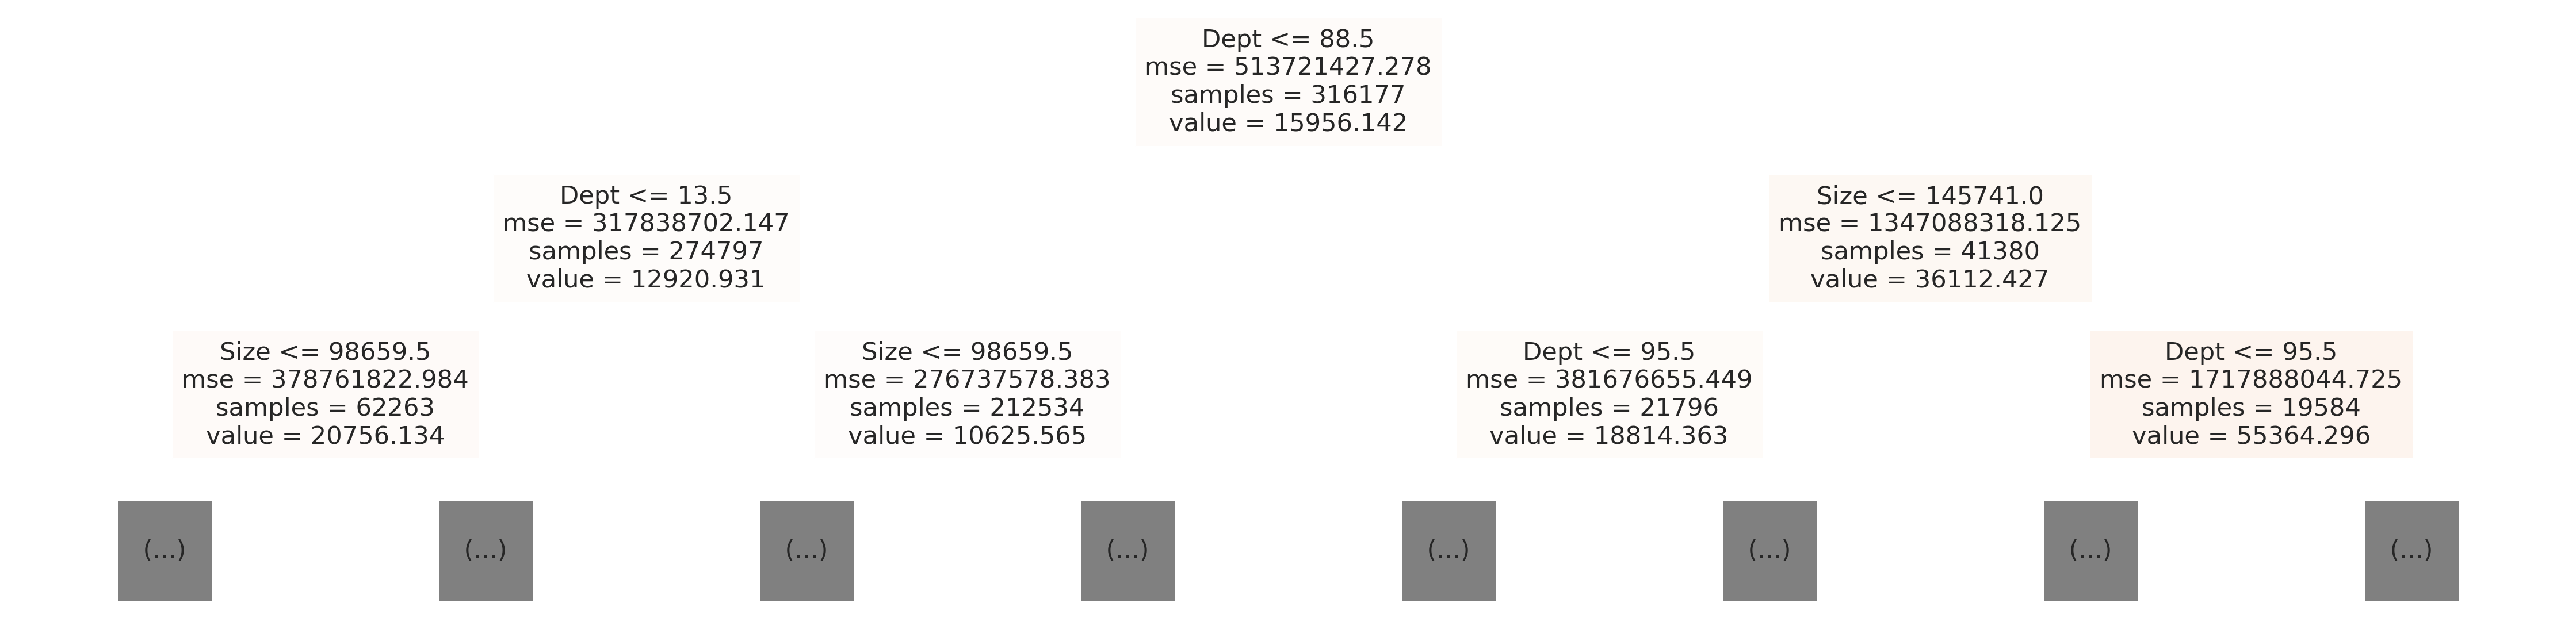

In [ ]:
#ploting top 2 depth of decision tree
plt.figure(figsize=(80,20))
_=plot_tree(tree,max_depth=2,feature_names=train_inputs.columns, filled=True)

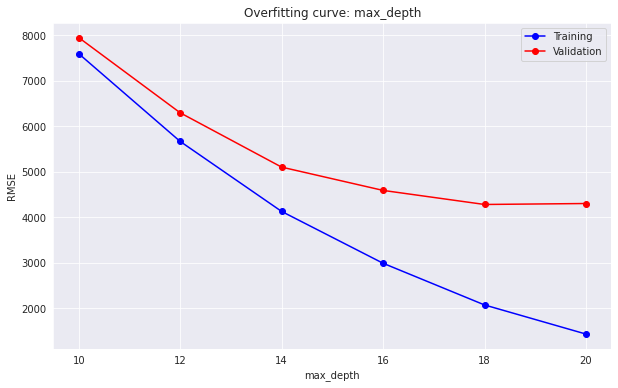

In [ ]:
test_tree_param_and_plot('max_depth',[10,12,14,16,18,20])

from the graph we can observe that 18 is the best value for max_depth

In [ ]:
#predicting with best hyper parameters
final_tree = DecisionTreeRegressor(max_depth=18,random_state=42)
final_tree.fit(train_inputs,train_targets)
train_rmse = rmse(train_targets,final_tree.predict(train_inputs))
val_rmse = rmse(val_targets,final_tree.predict(val_inputs))
model_rmse_df.loc[len(model_rmse_df.index)] = ['decision_tree',train_rmse,val_rmse]

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/aswanthjeje28/walmart-sales-prediction


'https://jovian.ai/aswanthjeje28/walmart-sales-prediction'

## RandomForest

In [ ]:
#building and predicting base random forest model
rf = RandomForestRegressor(n_jobs=-1,n_estimators=12,random_state=42)
rf.fit(train_inputs,train_targets)
train_preds = rf.predict(train_inputs)
val_preds = rf.predict(val_inputs)
base_acc = (rmse(train_targets,train_preds),rmse(val_targets,val_preds))

In [ ]:
base_acc

(1484.165766656387, 3501.199411762017)

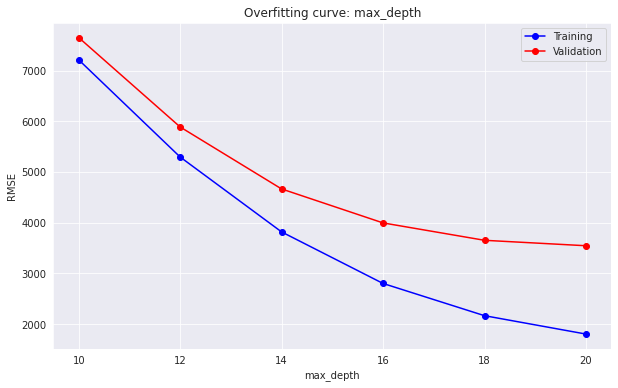

In [ ]:
test_rf_param_and_plot('max_depth',np.arange(10,21,2))

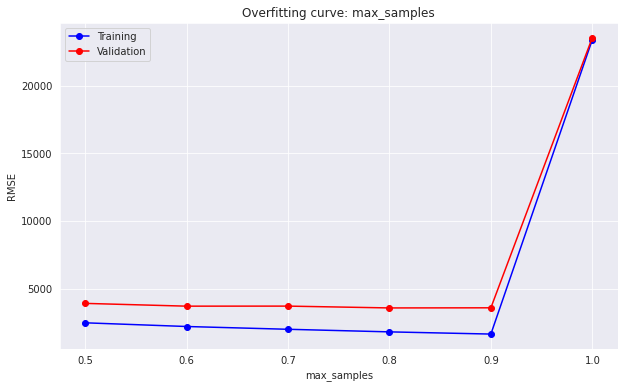

In [ ]:
test_rf_param_and_plot('max_samples',[0.5,0.6,0.7,0.8,0.9,1])

In [ ]:
#predicting with best hyper parameters
final_rf = RandomForestRegressor(n_jobs=-1,n_estimators=12,min_impurity_decrease=1e-5,random_state=42)
final_rf.fit(train_inputs,train_targets)
train_rmse = rmse(train_targets,final_rf.predict(train_inputs))
val_rmse = rmse(val_targets,final_rf.predict(val_inputs))
model_rmse_df.loc[len(model_rmse_df.index)] = ['random_forest',train_rmse,val_rmse]

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/aswanthjeje28/walmart-sales-prediction


'https://jovian.ai/aswanthjeje28/walmart-sales-prediction'

## XGBoost

In [ ]:
xgb = XGBRegressor(random_state=42,n_jobs=-1,verbosity=0)
xgb.fit(train_inputs,train_targets)
train_preds = xgb.predict(train_inputs)
val_preds = xgb.predict(val_inputs)
base_acc = (rmse(train_targets,train_preds),rmse(val_targets,val_preds))

In [ ]:
base_acc

(11648.0539961565, 11944.117299792286)

In [ ]:
test_xgb_params(objectve='reg:squarederror',learning_rate=0.5,max_depth=12)

(912.0432197526761, 3079.177157844145)

In [ ]:
#test_xgb_param_and_plot('max_depth',[8,10,12,14,16])

In [ ]:
#predicting with best hyper parameters
final_xgb = XGBRegressor(verbosity=0,learning_rate=0.5,max_depth=12,objective='reg:squarederror',random_state=42)
final_xgb.fit(train_inputs,train_targets)
train_rmse = rmse(train_targets,final_xgb.predict(train_inputs))
val_rmse = rmse(val_targets,final_xgb.predict(val_inputs))
model_rmse_df.loc[len(model_rmse_df.index)] = ['xgboost',train_rmse,val_rmse]

In [ ]:
#saving parameters for final model
params = final_xgb.get_params()

In [ ]:
model_rmse_df

,model,train_rmse,val_rmse
0,decision_tree,2073.440588,4282.337914
1,random_forest,1499.955578,3488.120281
2,xgboost,912.043220,3079.177158


In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/aswanthjeje28/walmart-sales-prediction


'https://jovian.ai/aswanthjeje28/walmart-sales-prediction'

In [ ]:
xgb_feature_importance_df = pd.DataFrame({'features':train_inputs.columns,'importance':final_xgb.feature_importances_})

In [ ]:
xgb_feature_importance_df.sort_values('importance',ascending=False)

,features,importance
8,Size,0.362280
1,Dept,0.249201
7,Type,0.170083
13,WeekOfYear,0.050905
0,Store,0.047783
10,Month,0.045383
12,Sales_Temp_Corr,0.025065
5,CPI,0.013592
2,IsHoliday,0.008454
6,Unemployment,0.008234


In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/aswanthjeje28/walmart-sales-prediction


'https://jovian.ai/aswanthjeje28/walmart-sales-prediction'

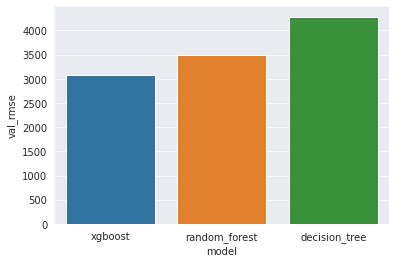

In [ ]:
sns.barplot(x='model',y='val_rmse',data=model_rmse_df.sort_values('val_rmse',
                                                                  ascending=True))

model using XGBoost predicts well on the data. It gets the least rmse score.
So we will use xgboost as our model(with same hyper parameters) for predicting test datasets

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/aswanthjeje28/walmart-sales-prediction


'https://jovian.ai/aswanthjeje28/walmart-sales-prediction'

#Building final model and Making Prediction on Test set

We've selected the XGBoost algorithm for our final model.Now we will merge train and validation set and we will use whole data for the training purpose. this will boost the model efficiency. Then prediction will be made on test set which is target value is unknown. After prediction on test set, Upload prediction to kaggle competition page and check the score

In [ ]:
full_train_df = pd.concat([train_df,val_df]).reset_index()

In [ ]:
model= XGBRegressor(**params)
model.fit(full_train_df[features],full_train_df[target])
test_preds = model.predict(test_df[features])

In [ ]:
submission_df = pd.DataFrame(columns=['Id',target])

In [ ]:
ss[target] = test_preds

In [ ]:
ss.to_csv('submission.csv',index=False)

File has submitted to kaggle. I got a score of 25055.58

#Sample Prediction

Here we will predict on a single row of input

In [ ]:
#this function will predict on a single value input
def predict_input(model,single_input):
  input_df=pd.DataFrame([single_input])
  input_df['Date'] = pd.to_datetime(input_df['Date'])
  input_df['Day'] = input_df['Date'].dt.day
  input_df['Month'] = input_df['Date'].dt.month
  input_df['Year'] = input_df['Date'].dt.year
  input_df['Sales_Temp_Corr'] = sales_temp_corr_df.query(f'Store=={input_df.Store.item()} and Dept=={input_df.Dept.item()}')['Sales_Temp_Corr'].item()
  input_df['WeekOfYear'] = input_df['Date'].dt.week
  input_df['WeekOfMonth'] = input_df.Day//7+1
  input_df.drop(['Date'],axis=1,inplace=True)
  input_df.Holiday =input_df.IsHoliday.astype(int)
  input_df['Type'] = input_df['Type'].map({'A':3,'B':2,'C':1})
  return model.predict(input_df)[0]

In [ ]:
new_input ={
    'Store':33,
    'Dept':4,
    'Date':'2013-07-05',
    'IsHoliday':False,
    'Temperature':99.66,
    'Fuel_Price':3.753,
    'CPI':207.6,
    'Unemployment':7.11,
    'Type':'A',
    'Size':39690
}

In [ ]:
#prediction of sales in the new input
predict_input(model,new_input)

10193.03

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/aswanthjeje28/walmart-sales-prediction


'https://jovian.ai/aswanthjeje28/walmart-sales-prediction'

# Saving the model 

In [ ]:
import joblib

In [ ]:
walmart_sales = {
    'model':model,
    'features':features,
    'target':target,
    'train_inputs':full_train_df[features],
    'train_targets':full_train_df[target],

}
joblib.dump(walmart_sales,'walmart_sales.joblib')

['walmart_sales.joblib']

In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/aswanthjeje28/walmart-sales-prediction


'https://jovian.ai/aswanthjeje28/walmart-sales-prediction'

#Summary,Reference and Future Ideas

##Summary

Steps in the project
1.   Downloaded the dataset from kaggle and load it
2.   Data preparation before the visualization
3.   Data visualization
4.   Data Prepration

>*   Missing value imputation
*   Encoding
*   Feature engineering

5.   Modeling
6.   Sample prediction

















##Reference

1.   XGBoost parameter documentation - https://xgboost.readthedocs.io/en/latest/parameter.html
2.   Sklearn decision tree documentation - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor
3.   sklearn random forest documentation - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
4.   Giving color to heatmap - https://www.python-graph-gallery.com/92-control-color-in-seaborn-heatmaps

5. Handling missing data - https://www.youtube.com/watch?v=P_iMSYQnqac





##Future Ideas

1.   Add more features by doing feature engineering
2.   Neural networks are really good at predicting continuos variable. Using tensorflow create neural network and make less rmse score for the prediction





In [ ]:
jovian.commit()

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/aswanthjeje28/walmart-sales-prediction


'https://jovian.ai/aswanthjeje28/walmart-sales-prediction'